In [191]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [192]:
filepath = 'CIP_2025.xlsx'
data = pd.read_excel(filepath, sheet_name=None)

exchange_rates, forward_rates, interest_rates = data['Spot'].set_index('Date'), data['Forward'].set_index('Date'), data['OIS'].set_index('Date')

cols = ["AUD", "CAD", "CHF", "EUR", "GBP", "JPY", "NZD", "SEK"]
exchange_rates.columns=cols
forward_rates.columns=cols

# The forward df is actually forward points, so we need to make this into forward rates.
forward_rates[[c for c in cols if c != 'JPY']] /= 10000
forward_rates['JPY'] /= 100
forward_rates = exchange_rates + forward_rates
#forward_rates[['JPY', 'EUR', 'GBP', 'NZD', 'AUD']]

exchange_rates.columns = [name+"_CURNCY" for name in exchange_rates.columns]
forward_rates.columns = [name+"_CURNCY3M" for name in forward_rates.columns]
interest_rates.columns = [name+"_IR" for name in interest_rates.columns]

In [193]:
#display(exchange_rates.head(), forward_rates.head(), interest_rates.head())

In [194]:
df_merged = (exchange_rates
             .merge(forward_rates, left_index=True, right_index=True, how='inner')
             .merge(interest_rates, left_index=True, right_index=True, how='inner'))


reciprocal_currencies = ['EUR', 'GBP', 'AUD', 'NZD']

for ccy in reciprocal_currencies:
    df_merged[f"{ccy}_CURNCY"] = 1 / df_merged[f"{ccy}_CURNCY"]
    df_merged[f"{ccy}_CURNCY3M"] = 1 / df_merged[f"{ccy}_CURNCY3M"]

In [195]:
currencies = ['AUD', 'CAD', 'CHF', 'EUR', 'GBP', 'JPY', 'NZD', 'SEK']

######################################
# Compute the log CIP basis in basis points
######################################
for ccy in currencies:
    fwd_col   = f'{ccy}_CURNCY3M'  
    spot_col  = f'{ccy}_CURNCY'    
    ir_col    = f'{ccy}_IR'        
    usd_ir_col = 'USD_IR'

    cip_col = f'CIP_{ccy}_ln'
    df_merged[cip_col] = 100*100 * (
        (df_merged[ir_col] / 100.0)
        - (360.0 / 90.0) * (
            np.log(df_merged[fwd_col]) - np.log(df_merged[spot_col])
        )
        - (df_merged[usd_ir_col] / 100.0)
    )

######################################
# Rolling outlier cleanup (45-day window)
# This emulates STATA's rangestat median & MAD
######################################

window_size = 45
for ccy in currencies:
    cip_col = f'CIP_{ccy}_ln'
    
    # Rolling median over 45 days
    rolling_median = df_merged[cip_col].rolling(window_size).median()
    # Absolute deviation from median
    abs_dev = (df_merged[cip_col] - rolling_median).abs()
    # Rolling mean of abs_dev (i.e. a proxy for MAD)
    rolling_mad = abs_dev.rolling(window_size).mean()
    
    # Mark outliers (abs_dev / mad >= 10)
    outlier_mask = (abs_dev / rolling_mad) >= 10
    df_merged.loc[outlier_mask, cip_col] = np.nan

spreads = df_merged[[f'CIP_{c}_ln' for c in cols]]
spreads.columns = [c[4:7] for c in spreads.columns]

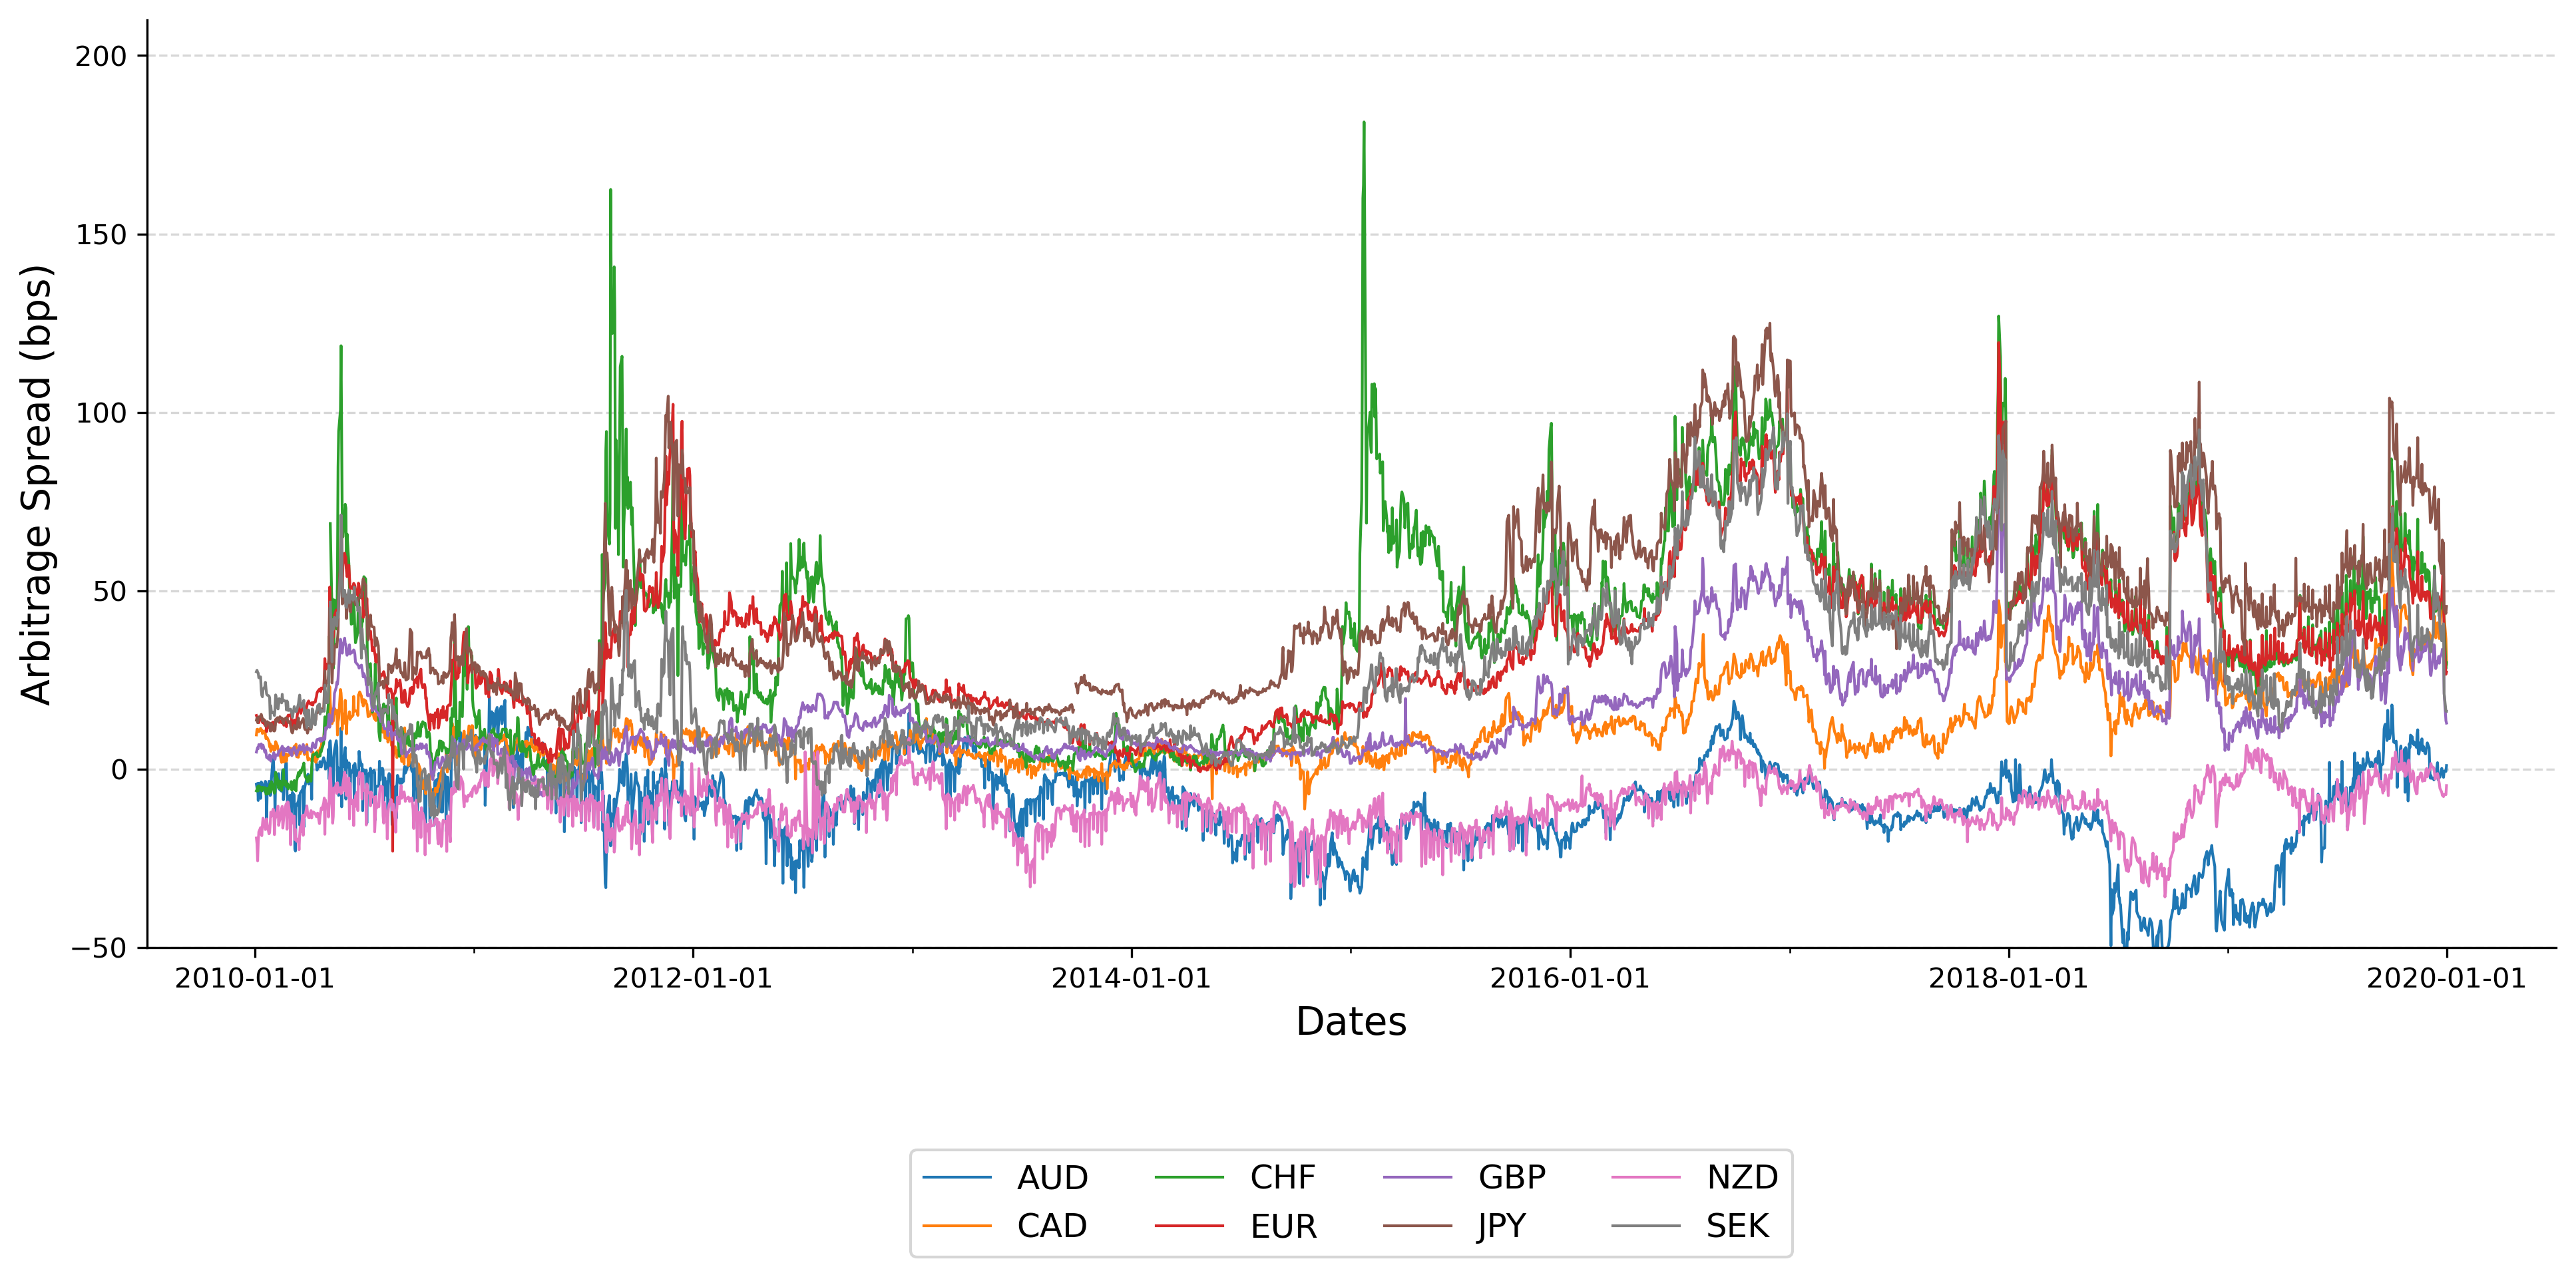

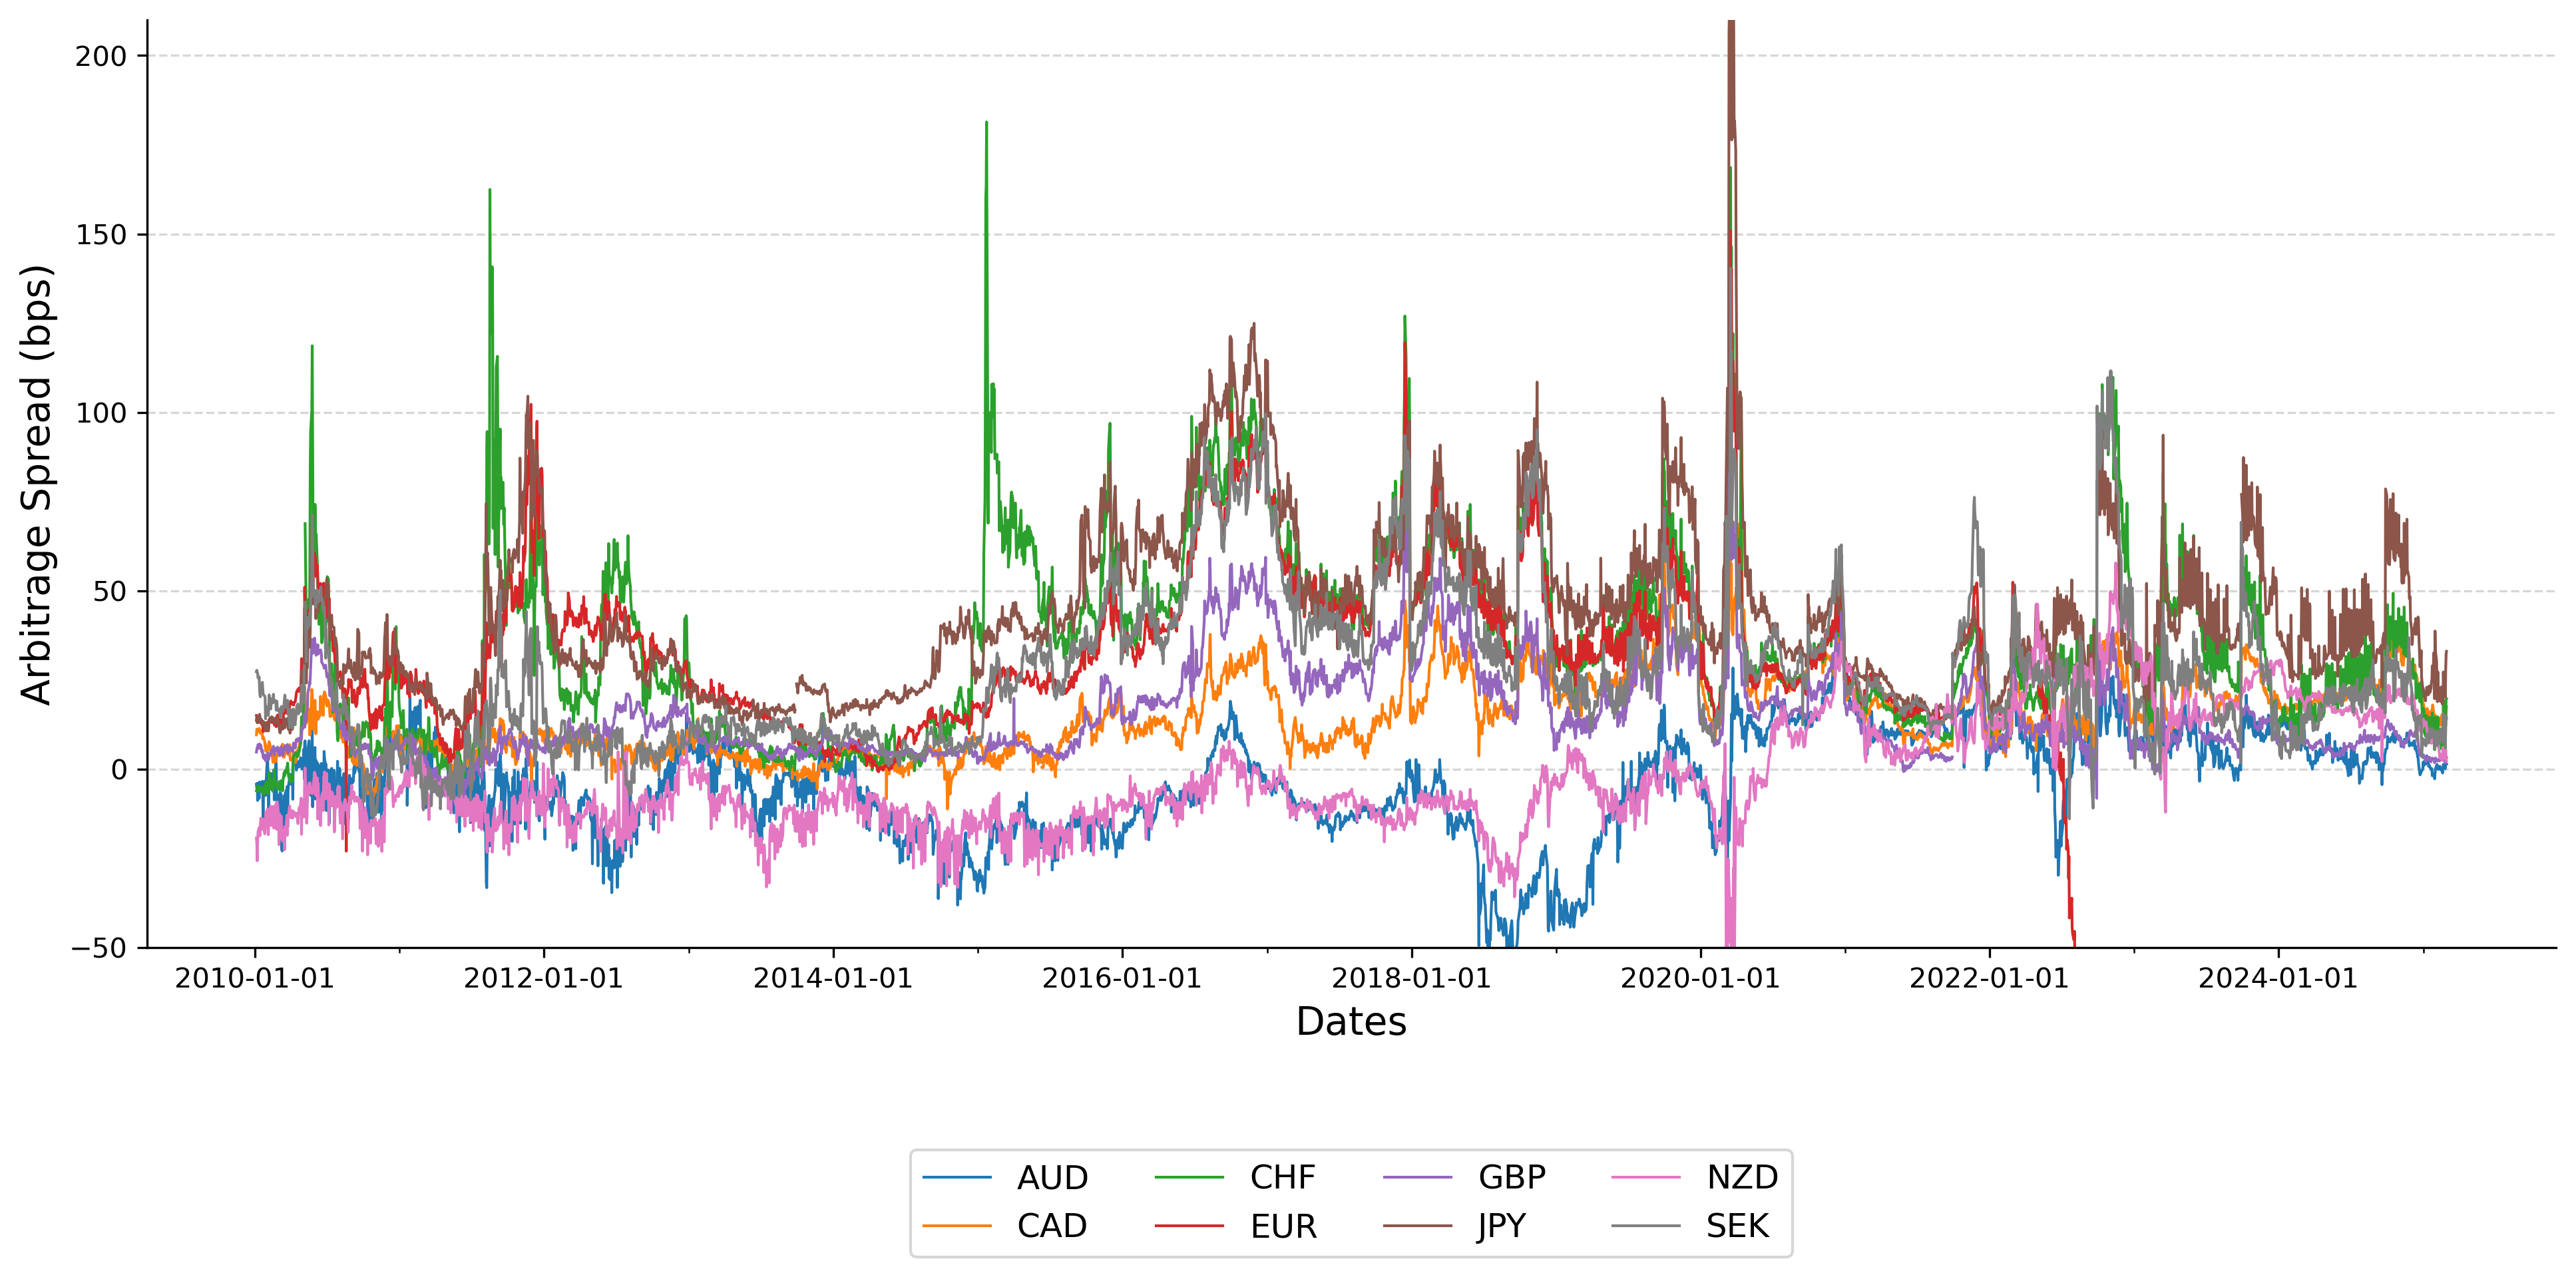

In [197]:
def plot_spreads(spreads, yr):
    
    fig, ax = plt.subplots(figsize=(13, 8), dpi=300)

    # Plot each column in the DataFrame
    for column in spreads.columns:
        ax.plot(spreads.index, spreads[column], label=column, linewidth=1, antialiased=True)

    # Set labels
    ax.set_xlabel("Dates", fontsize=14)
    ax.set_ylabel("Arbitrage Spread (bps)", fontsize=14)

    # Format x-axis for clean date labels
    ax.xaxis.set_major_locator(mdates.YearLocator(2))  # Major ticks every 2 years
    ax.xaxis.set_minor_locator(mdates.YearLocator(1))  # Minor ticks every year
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Full date format

    # Keep x-axis labels **straight** (horizontal)
    plt.xticks(rotation=0)

    # Remove **vertical** grid lines while keeping horizontal ones
    ax.yaxis.grid(True, linestyle="--", alpha=0.5)
    ax.xaxis.grid(False)  # Disable vertical grid lines

    # **Set y-axis limit to ensure 200 is clearly marked**
    ax.set_ylim([-50, 210])

    # Place the legend **fully below** the plot
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4, fontsize=12, frameon=True)

    # Remove top and right spines for a clean look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Adjust layout to ensure legend is fully visible
    plt.tight_layout(rect=[0, 0.15, 1, 1])

    # Save the figure in high quality
    plt.savefig(f"spread_plot_{yr}.pdf", format="pdf", bbox_inches='tight')  # Best for reports
    plt.savefig(f"spread_plot_{yr}.png", dpi=300, bbox_inches='tight')  # Best for viewing

plot_spreads(spreads.loc[:'2019'], 'rep')
plot_spreads(spreads, 'recent')